In [20]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, classification_report
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFECV

import xgboost as xgb

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [21]:
def feature_importance(X, y, model_instance, feature_names, fi_name):
    #takes in features (X) and classess (y), model, column names for features in X, and name of attribute for feature importance
    #returns dictionary of feature names and coef/feature importance values
    
    feature_importance_dic = {}
    
    model_instance.fit(X, y)
    
    if fi_name == 'coef':
        coef = model_instance.coef_[0]
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'feature_importance':
        coef = model_instance.feature_importances_
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'none':
        coef = np.zeros(len(feature_names))
        feature_importance_dic = dict(zip(feature_names, coef))
    
    return feature_importance_dic

In [22]:
def classification_pipeline(X, y, cv_instance, model_instance, feature_names, fi_name):
    
    #scale data
    data_scaled = scaler.fit_transform(X)
    
    #generate cross-val sets
    cv = list(cv_instance.split(data_scaled, y))
    
    #predict class and predict probability 
    y_pred = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict')
    y_pred_prob = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict_proba')
    
    #generate confusion matrix
    conf_mat = confusion_matrix(y, y_pred)
    print('Confusion matrix:', conf_mat)
    
    #generate ROC_AUC
    ROC_AUC = metrics.roc_auc_score(y, y_pred_prob[:,1])
    print("ROC_AUC: ", ROC_AUC)
    
    # generate additional metrics
    recall = metrics.recall_score(y,y_pred)
    precision = metrics.precision_score(y,y_pred)
    accuracy = metrics.accuracy_score(y,y_pred)
    F1 = metrics.f1_score(y,y_pred)
    print("Sensitivity/Recall (TPR): ",recall)
    print("Precision (PPV): ", precision)
    print("Accuracy: ", accuracy)
    print("F1:", F1)
    
    #determine feature importance
    feature_dic = feature_importance(data_scaled, y, model_instance, feature_names, fi_name)
    
    #create dic
    data_dic = {}
    data_dic['y_pred'] = y_pred
    data_dic['y_pred_prob'] = y_pred_prob
    data_dic['conf_mat'] = conf_mat
    data_dic['ROC_AUC'] = ROC_AUC
    data_dic['recall'] = recall
    data_dic['precision'] = precision
    data_dic['accuracy'] = accuracy
    data_dic['F1'] = F1
    
    data_dic = {**data_dic, **feature_dic}
    
    return data_dic

In [23]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe, model_name):
    preds = []
    for index, row in dataframe.iterrows():

        if (row['Group'] == 0) & (row[model_name] == 0):
            pred = 'TN'
        if (row['Group'] == 0) & (row[model_name] == 1):
            pred = 'FP'
        if (row['Group'] == 1) & (row[model_name] == 1):
            pred = 'TP'
        if (row['Group'] == 1) & (row[model_name] == 0):
            pred = 'FN'
          
        preds.append(pred)
      
    dataframe[str('pred_' + model_name)] = preds
    return dataframe

### Preprocess data

In [24]:
path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Phillips/Combined.xlsx'

In [25]:
#excel file containing multiple sheets with rat cocaine self administration data (day 1 of training through reaching criteria)
#original file has multiple sheets (for different feature types) - most sheets have multiple days (columns) of training data
#use first five days and last five days of training as feature data (6 different self administration parameters to use)
#singe data point of days to criterion - use also

whole_file = pd.ExcelFile(path)

print(whole_file.sheet_names)

combined_data = pd.DataFrame()

for sheet_name in whole_file.sheet_names:
    print(sheet_name)

    if sheet_name != 'days2crit':
        
        sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name, header=None))
        sheet_data.rename({0: 'Group', 1: 'Animal'}, inplace=True, axis=1)
        sheet_data = sheet_data[['Group', 'Animal', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
           16, 17, 18, 19, 20, 21, 22, 23]]

        for index, row in sheet_data.iterrows():
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_5')] = row.dropna()[-5]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_4')] = row.dropna()[-4]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_3')] = row.dropna()[-3]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_2')] = row.dropna()[-2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_1')] = row.dropna()[-1]
            
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus1')] = row.dropna()[2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus2')] = row.dropna()[3]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus3')] = row.dropna()[4]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus4')] = row.dropna()[5]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus5')] = row.dropna()[6]
            
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_full_ave')] = row.dropna()[2:].mean()
            
        sheet_data = sheet_data[['Animal', 'Group', 
                                 str(sheet_name + '_plus1'), \
                                str(sheet_name + '_plus2'), \
                                str(sheet_name + '_plus3'), \
                                str(sheet_name + '_plus4'), \
                                str(sheet_name + '_plus5'), \
                                 str(sheet_name + '_minus_5'), \
                                str(sheet_name + '_minus_4'), \
                                str(sheet_name + '_minus_3'), \
                                str(sheet_name + '_minus_2'), \
                                str(sheet_name + '_minus_1'),
                                str(sheet_name + '_full_ave')]]
        
        sheet_data[str(sheet_name + '_last_ave')] = sheet_data.loc[:, str(sheet_name + '_minus_5'): str(sheet_name + '_minus_1')].mean(axis=1)
        sheet_data[str(sheet_name + '_first_ave')] = sheet_data.loc[:, str(sheet_name + '_plus1'): str(sheet_name + '_plus5')].mean(axis=1)
    
    if sheet_name == 'days2crit':
        sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name, header=None))
        sheet_data.rename({0: 'Group', 1: 'Animal'}, inplace=True, axis=1)
        sheet_data = sheet_data[['Group', 'Animal', 2]]
    
    if combined_data.shape[0] == 0:
        combined_data = sheet_data
    else:
        combined_data = pd.merge(combined_data, sheet_data, how='inner', on=['Animal', 'Group'], suffixes=(sheet_name, sheet_name))

combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
combined_data.rename({2:'days2crit'}, axis=1, inplace=True)
combined_data.head(1)

['actnp', 'Inactnp', 'actTO', 'avgIII', 'inactTO', 'days2crit', 'lat2fir']
actnp
Inactnp
actTO
avgIII
inactTO
days2crit
lat2fir
(80, 81)


,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_full_ave,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_full_ave,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_full_ave,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_full_ave,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_full_ave,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_full_ave,lat2fir_last_ave,lat2fir_first_ave
0,2223,1,8.0,17.0,15.0,23.0,19.0,27.0,20.0,21.0,7.0,19.0,18.272727,18.8,16.4,8.0,10.0,5.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,3.333333,1.0,5.6,2.0,9.0,1.0,3.0,3.0,4.0,3.0,1.0,3.0,3.0,4.583333,2.8,3.6,433.69429,215.425,241.95429,156.70045,198.64611,130.57462,182.12895,170.5415,202.24412,189.33389,205.107868,174.964616,249.284028,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.0,0.8,4,68.11,73.63,85.62,42.51,10.25,31.86,77.88,26.81,2640.67,75.58,295.264545,570.56,56.024


In [26]:
combined_data['Group'] = combined_data['Group'].replace({1:1, 2:0})
combined_data['Group'].value_counts()

0    54
1    26
Name: Group, dtype: int64

### Manual feature selection and model training evaluation

In [27]:
corr = combined_data[['Group',
                      'actnp_full_ave',
                     'Inactnp_full_ave',
               'actTO_full_ave', 
                'avgIII_full_ave',
                     'inactTO_full_ave',
                     'lat2fir_full_ave',
                      'actnp_first_ave',
                     'Inactnp_first_ave',
               'actTO_first_ave', 
                'avgIII_first_ave',
                     'inactTO_first_ave',
                     'lat2fir_first_ave',
                    'actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
                     'lat2fir_last_ave',
                     'days2crit']].corr()
corr['Group'].sort_values()

actnp_last_ave      -0.456604
actnp_full_ave      -0.433003
actnp_first_ave     -0.312006
actTO_full_ave      -0.264634
actTO_last_ave      -0.235893
actTO_first_ave     -0.218764
Inactnp_last_ave    -0.185934
inactTO_full_ave    -0.078784
inactTO_first_ave   -0.078286
Inactnp_full_ave    -0.056993
inactTO_last_ave    -0.050435
lat2fir_last_ave    -0.038895
lat2fir_full_ave    -0.011062
Inactnp_first_ave    0.042428
lat2fir_first_ave    0.132765
days2crit            0.172686
avgIII_first_ave     0.174101
avgIII_full_ave      0.238071
avgIII_last_ave      0.299862
Group                1.000000
Name: Group, dtype: float64

In [97]:
features_full = ['actnp_plus1', 'actnp_plus2', 'actnp_plus3',
       'actnp_plus4', 'actnp_plus5', 'actnp_minus_5', 'actnp_minus_4',
       'actnp_minus_3', 'actnp_minus_2', 'actnp_minus_1', 
       'actTO_plus1', 'actTO_plus2', 'actTO_plus3', 'actTO_plus4',
       'actTO_plus5', 'actTO_minus_5', 'actTO_minus_4', 'actTO_minus_3',
       'actTO_minus_2', 'actTO_minus_1', 'avgIII_plus1',
       'avgIII_plus2', 'avgIII_plus3', 'avgIII_plus4', 'avgIII_plus5',
       'avgIII_minus_5', 'avgIII_minus_4', 'avgIII_minus_3',
       'avgIII_minus_2', 'avgIII_minus_1', 'inactTO_plus1',
       'inactTO_plus2', 'inactTO_plus3', 'inactTO_plus4', 'inactTO_plus5',
       'inactTO_minus_5', 'inactTO_minus_4', 'inactTO_minus_3',
       'inactTO_minus_2', 'inactTO_minus_1', 
       'days2crit']

features_ave_full = ['actnp_full_ave',
               'actTO_full_ave', 
                     'inactTO_full_ave',
                'avgIII_full_ave',
                     'days2crit']

features_ave_firstlast = ['actnp_first_ave',
               'actTO_first_ave', 
                'avgIII_first_ave',
                    'actnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
          'days2crit']

features_ave_last = ['actnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
                    'days2crit']

all_ave = ['actnp_first_ave',
 'Inactnp_first_ave',
               'actTO_first_ave', 
                'avgIII_first_ave',
                     'inactTO_first_ave',
                     'lat2fir_first_ave',
                    'actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
                     'lat2fir_last_ave',
        'actnp_full_ave',
                     'Inactnp_full_ave',
               'actTO_full_ave', 
                'avgIII_full_ave',
                     'inactTO_full_ave',
                     'lat2fir_full_ave',
                     'days2crit']


actnp_first_ave


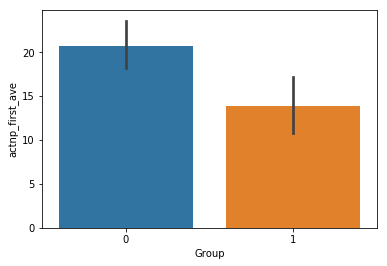

actTO_first_ave


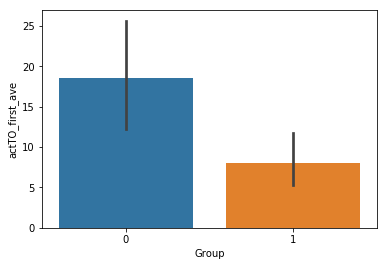

avgIII_first_ave


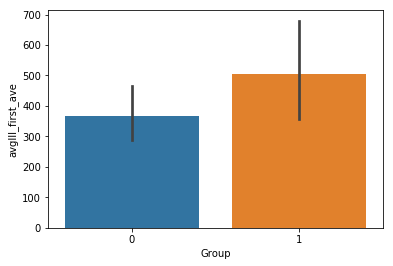

actnp_last_ave


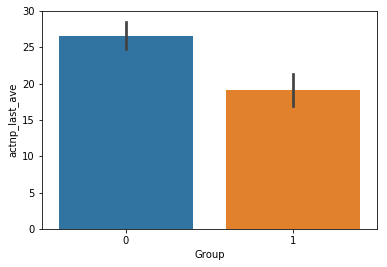

actTO_last_ave


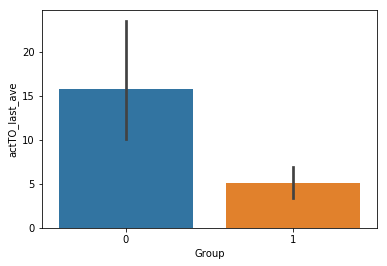

avgIII_last_ave


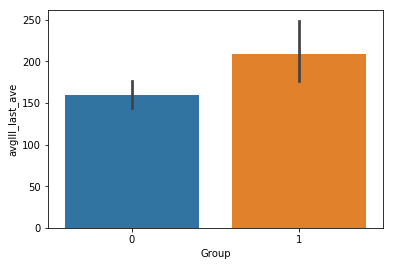

inactTO_last_ave


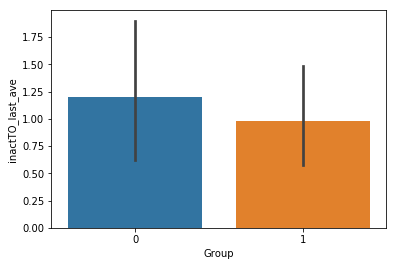

days2crit


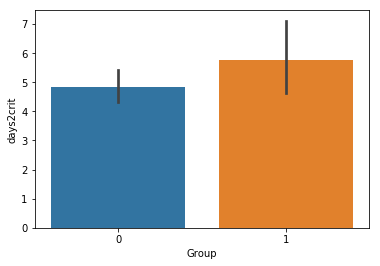

In [98]:
for param in features_ave_firstlast:
    print(param)
    sns.barplot(x=combined_data["Group"], y=combined_data[param])
    plt.show()

In [99]:
#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_full = train[features_full]
X_train_ave_full = train[features_ave_full]
X_train_ave_last = train[features_ave_last]
X_train_ave_firstlast = train[features_ave_firstlast]

X_test_full = test[features_full]
X_test_ave_full = test[features_ave_full]
X_test_ave_last = test[features_ave_last]
X_test_ave_firstlast = test[features_ave_firstlast]

In [100]:
#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=3)

#classifier algos
dm_cv = DummyClassifier(strategy='stratified', random_state=39)
lr_cv = LogisticRegression(random_state=39, class_weight='balanced')
rf_cv = RandomForestClassifier(random_state=39, class_weight='balanced')
svm_cv = SVC(kernel='linear', probability=True, class_weight='balanced') 
knn_cv = KNeighborsClassifier()
gb_cv = GradientBoostingClassifier(random_state=39)
ab_cv = AdaBoostClassifier(random_state=39)

#dic with classifier and feature importance attribute name
models_dic = {'dm_cv': (dm_cv, 'none'), 
              'lr_cv': (lr_cv, 'coef'), 
              'rf_cv': (rf_cv, 'feature_importance'), 
              'svm_cv':(svm_cv, 'coef'), 
              'knn_cv': (knn_cv, 'none'), 
              'gb_cv': (gb_cv, 'feature_importance'), 
              'ab_cv': (ab_cv, 'feature_importance')}

In [101]:
feature_set = 'full'
feature_names = features_full

data_full_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_full_features[name + '_' + feature_set] = classification_pipeline(X_train_full, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with full features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with full features:
Confusion matrix: [[25 13]
 [ 7 11]]
ROC_AUC:  0.6637426900584795
Sensitivity/Recall (TPR):  0.6111111111111112
Precision (PPV):  0.4583333333333333
Accuracy:  0.6428571428571429
F1: 0.5238095238095238


rf_cv model with full features:
Confusion matrix: [[34  4]
 [12  6]]
ROC_AUC:  0.5994152046783626
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.6
Accuracy:  0.7142857142857143
F1: 0.42857142857142855


svm_cv model with full features:
Confusion matrix: [[28 10]
 [ 8 10]]
ROC_AUC:  0.695906432748538
Sensitivity/Recall (TPR):  0.5555555555555556
Precision (PPV):  0.5
Accuracy:  0.6785714285714286
F1: 0.5263157894736842


knn_cv model with full features:
Confusion matrix: [[27 11]
 [10  8]]
ROC_AUC:  0.6154970760233919

In [102]:
feature_set = 'ave_full'
feature_names = features_ave_full

data_ave_full_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_ave_full_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_full, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with ave_full features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with ave_full features:
Confusion matrix: [[23 15]
 [ 5 13]]
ROC_AUC:  0.631578947368421
Sensitivity/Recall (TPR):  0.7222222222222222
Precision (PPV):  0.4642857142857143
Accuracy:  0.6428571428571429
F1: 0.5652173913043479


rf_cv model with ave_full features:
Confusion matrix: [[31  7]
 [14  4]]
ROC_AUC:  0.7002923976608187
Sensitivity/Recall (TPR):  0.2222222222222222
Precision (PPV):  0.36363636363636365
Accuracy:  0.625
F1: 0.27586206896551724


svm_cv model with ave_full features:
Confusion matrix: [[21 17]
 [ 6 12]]
ROC_AUC:  0.6622807017543859
Sensitivity/Recall (TPR):  0.6666666666666666
Precision (PPV):  0.41379310344827586
Accuracy:  0.5892857142857143
F1: 0.5106382978723404


knn_cv model with ave_full features:
Confusion matrix: [[33  5]

In [103]:
feature_set = 'firstlast'
feature_names = features_ave_firstlast

data_firstlast_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_firstlast_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_firstlast, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with firstlast features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with firstlast features:
Confusion matrix: [[22 16]
 [ 7 11]]
ROC_AUC:  0.6388888888888888
Sensitivity/Recall (TPR):  0.6111111111111112
Precision (PPV):  0.4074074074074074
Accuracy:  0.5892857142857143
F1: 0.4888888888888889


rf_cv model with firstlast features:
Confusion matrix: [[32  6]
 [16  2]]
ROC_AUC:  0.6666666666666667
Sensitivity/Recall (TPR):  0.1111111111111111
Precision (PPV):  0.25
Accuracy:  0.6071428571428571
F1: 0.15384615384615383


svm_cv model with firstlast features:
Confusion matrix: [[24 14]
 [ 6 12]]
ROC_AUC:  0.6710526315789473
Sensitivity/Recall (TPR):  0.6666666666666666
Precision (PPV):  0.46153846153846156
Accuracy:  0.6428571428571429
F1: 0.5454545454545455


knn_cv model with firstlast features:
Confusion matrix: [[31

In [104]:
feature_set = 'ave_last'
feature_names = features_ave_last

data_ave_last_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_ave_last_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_last, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with ave_last features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with ave_last features:
Confusion matrix: [[26 12]
 [ 8 10]]
ROC_AUC:  0.6842105263157895
Sensitivity/Recall (TPR):  0.5555555555555556
Precision (PPV):  0.45454545454545453
Accuracy:  0.6428571428571429
F1: 0.5


rf_cv model with ave_last features:
Confusion matrix: [[33  5]
 [12  6]]
ROC_AUC:  0.7222222222222223
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.5454545454545454
Accuracy:  0.6964285714285714
F1: 0.41379310344827586


svm_cv model with ave_last features:
Confusion matrix: [[26 12]
 [ 9  9]]
ROC_AUC:  0.7090643274853801
Sensitivity/Recall (TPR):  0.5
Precision (PPV):  0.42857142857142855
Accuracy:  0.625
F1: 0.4615384615384615


knn_cv model with ave_last features:
Confusion matrix: [[29  9]
 [10  8]]
ROC_AUC:  0.659356

In [105]:
#put dics in pandas df 
final_dic = {**data_full_features, **data_ave_full_features, **data_firstlast_features, **data_ave_last_features}
data_pandas = pd.DataFrame.from_dict(data = final_dic, orient='index')
data_pandas.sort_values('F1', ascending=False)
#data_pandas.sort_index()

,y_pred,y_pred_prob,conf_mat,ROC_AUC,recall,precision,accuracy,F1,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,days2crit,actnp_full_ave,actTO_full_ave,inactTO_full_ave,avgIII_full_ave,actnp_first_ave,actTO_first_ave,avgIII_first_ave,actnp_last_ave,actTO_last_ave,avgIII_last_ave,inactTO_last_ave
gb_cv_ave_full,"[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, ...","[[0.002486000148169909, 0.9975139998518301], [...","[[29, 9], [5, 13]]",0.751462,0.722222,0.590909,0.750000,0.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.105523,0.514548,0.048372,0.244859,0.086698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ab_cv_ave_full,"[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...","[[0.25982876851265396, 0.7401712314873461], [0...","[[30, 8], [6, 12]]",0.741959,0.666667,0.600000,0.750000,0.631579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140000,0.200000,0.300000,0.260000,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gb_cv_firstlast,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[[0.00554992008214783, 0.9944500799178522], [0...","[[32, 6], [8, 10]]",0.786550,0.555556,0.625000,0.750000,0.588235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007506,NaN,NaN,NaN,NaN,0.076834,0.091188,0.058741,0.435364,0.211407,0.099827,0.019133
lr_cv_ave_full,"[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, ...","[[0.19386185639637943, 0.8061381436036206], [0...","[[23, 15], [5, 13]]",0.631579,0.722222,0.464286,0.642857,0.565217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.274828,-1.293689,-0.395775,-0.277892,-0.140752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
svm_cv_firstlast,"[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...","[[0.3443764165447469, 0.6556235834552533], [0....","[[24, 14], [6, 12]]",0.671053,0.666667,0.461538,0.642857,0.545455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.278221,NaN,NaN,NaN,NaN,-0.056216,-0.472434,-0.236653,-1.504400,-0.407078,-0.208616,0.427738
gb_cv_ave_last,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[[0.10752344361496113, 0.8924765563850389], [0...","[[31, 7], [9, 9]]",0.728070,0.500000,0.562500,0.714286,0.529412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449057,0.320916,0.136671,0.024327
svm_cv_full,"[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...","[[0.3426080401341502, 0.6573919598658498], [0....","[[28, 10], [8, 10]]",0.695906,0.555556,0.500000,0.678571,0.526316,-0.418449,-0.430962,-0.707137,0.003320,-0.592781,0.036880,-1.144014,-0.289982,-0.506617,0.668411,-0.054105,0.379792,-0.253287,-0.256876,-0.171988,-1.283035,-0.328437,-0.411127,-0.146994,0.448786,-0.335220,0.047754,0.404781,0.089466,0.044779,0.053553,-0.435781,-0.001181,0.288171,0.295156,0.327591,-0.002967,0.423158,1.191743,0.251984,-0.064046,-0.493674,-0.475370,0.470911,-0.312858,-0.555246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lr_cv_full,"[1, 0, 0, 0, 0

Text(0,0.5,'True Positive Rate (Sensitivity)')

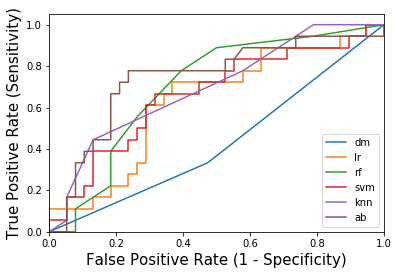

In [106]:
fpr_dm, tpr_dm, thresholds_dm = metrics.roc_curve(Y_train_class, data_ave_full_features['dm_cv_ave_full']['y_pred_prob'][:,1])
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(Y_train_class, data_ave_full_features['lr_cv_ave_full']['y_pred_prob'][:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(Y_train_class, data_ave_full_features['rf_cv_ave_full']['y_pred_prob'][:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(Y_train_class, data_ave_full_features['svm_cv_ave_full']['y_pred_prob'][:,1])
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(Y_train_class, data_ave_full_features['knn_cv_ave_full']['y_pred_prob'][:,1])
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(Y_train_class, data_ave_full_features['ab_cv_ave_full']['y_pred_prob'][:,1])


# plot model ROC curves
plt.plot(fpr_dm, tpr_dm, label="dm")
plt.plot(fpr_lr, tpr_lr, label="lr")
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_knn, tpr_knn, label="knn")
plt.plot(fpr_ab, tpr_ab, label="ab")

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0,0.5,'Precision')

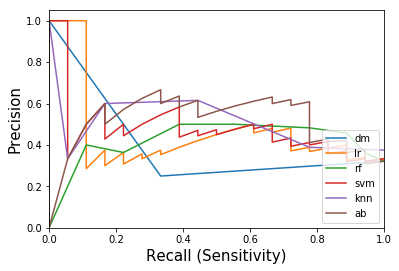

In [107]:
# calculate precision-recall curve
precision_dm, recall_dm, thresholds_pr_dm = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['dm_cv_ave_full']['y_pred_prob'][:,1])
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['lr_cv_ave_full']['y_pred_prob'][:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['rf_cv_ave_full']['y_pred_prob'][:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['svm_cv_ave_full']['y_pred_prob'][:,1])
precision_knn, recall_knn, thresholds_pr_knn = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['knn_cv_ave_full']['y_pred_prob'][:,1])
precision_ab, recall_ab, thresholds_pr_ab = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['ab_cv_ave_full']['y_pred_prob'][:,1])

plt.plot(recall_dm, precision_dm, label='dm')
plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')
plt.plot(recall_knn, precision_knn, label='knn')
plt.plot(recall_ab, precision_ab, label='ab')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

In [108]:
#scale data for grid search
train_scaled = scaler.fit_transform(X_train_ave_full)

#grid search with cv for ada and ave last features
param_grid = {'n_estimators':(25, 50, 100, 250), 'learning_rate':(0.1, 1.0), 'algorithm':('SAMME', 'SAMME.R')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

ab_base = AdaBoostClassifier(random_state=39)

ab_gs = GridSearchCV(ab_base, param_grid, cv=3, scoring = scoring, refit='f1')
ab_gs.fit(train_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(ab_gs, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(ab_gs, train_scaled, Y_train_class, scoring='roc_auc'))))

print(ab_gs.best_params_)

f1:0.6103896103896105
ROC_AUC:0.7453703703703703
{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 50}


In [116]:
#use best params

ada_best = AdaBoostClassifier(algorithm='SAMME', learning_rate=1.0, n_estimators=50, random_state=39)

print("f1:"+str(np.average(cross_val_score(ada_best, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(ada_best, train_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(ada_best, train_scaled, Y_train_class, scoring='accuracy'))))

ada_best.fit(train_scaled, Y_train_class)
print(ada_best.score(train_scaled, Y_train_class))

train_pred_ada = ada_best.predict(train_scaled)
train_pred_prob_ada = ada_best.predict_proba(train_scaled)
print(classification_report(Y_train_class, train_pred_ada))
print(confusion_matrix(Y_train_class, train_pred_ada))

f1:0.6825396825396824
ROC_AUC:0.7496438746438746
Accuracy:0.7855750487329435
0.9821428571428571
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.95      1.00      0.97        18

   micro avg       0.98      0.98      0.98        56
   macro avg       0.97      0.99      0.98        56
weighted avg       0.98      0.98      0.98        56

[[37  1]
 [ 0 18]]


In [117]:
#run on test data
#scale data
test_scaled = scaler.fit_transform(X_test_ave_full)

print('Adaboost test AUC: {}'.format(ada_best.score(test_scaled, Y_test_class)))
test_pred_ada = ada_best.predict(test_scaled)
test_pred_prob_ada = ada_best.predict_proba(test_scaled)
print(classification_report(Y_test_class, test_pred_ada))
print(confusion_matrix(Y_test_class, test_pred_ada))

Adaboost test AUC: 0.7916666666666666
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.71      0.62      0.67         8

   micro avg       0.79      0.79      0.79        24
   macro avg       0.77      0.75      0.76        24
weighted avg       0.79      0.79      0.79        24

[[14  2]
 [ 3  5]]


In [118]:
#scale data for grid search
train_scaled = scaler.fit_transform(X_train_ave_full)

#grid search with cv for svm and ave last features
param_grid = {'C':(0.001, 0.01, 0.1, 1, 10), 'decision_function_shape':('ovo','ovr')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

svm_base = SVC(kernel='linear', class_weight='balanced', random_state=39)

svm_gs = GridSearchCV(svm_base, param_grid, cv=3, scoring = scoring, refit='f1')
svm_gs.fit(train_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(svm_gs, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_gs, train_scaled, Y_train_class, scoring='roc_auc'))))

print(svm_gs.best_params_)

f1:0.4782163742690058
ROC_AUC:0.6506410256410255
{'C': 10, 'decision_function_shape': 'ovo'}


In [119]:
#use best params

svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', C=10, decision_function_shape='ovo', random_state=39)
    
print("f1:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='accuracy'))))

svm_best.fit(train_scaled, Y_train_class)
print(svm_best.score(train_scaled, Y_train_class))

train_pred_svm = svm_best.predict(train_scaled)
train_pred_prob_svm = svm_best.predict_proba(train_scaled)
print(classification_report(Y_train_class, train_pred_svm))
print(confusion_matrix(Y_train_class, train_pred_svm))

f1:0.513888888888889
ROC_AUC:0.6716524216524217
Accuracy:0.5867446393762183
0.6607142857142857
              precision    recall  f1-score   support

           0       0.85      0.61      0.71        38
           1       0.48      0.78      0.60        18

   micro avg       0.66      0.66      0.66        56
   macro avg       0.67      0.69      0.65        56
weighted avg       0.73      0.66      0.67        56

[[23 15]
 [ 4 14]]


In [120]:
#run on test data
#scale data
test_scaled = scaler.fit_transform(X_test_ave_full)

print('SVM test AUC: {}'.format(svm_best.score(test_scaled, Y_test_class)))
test_pred_svm = svm_best.predict(test_scaled)
test_pred_prob_svm = svm_best.predict_proba(test_scaled)
print(classification_report(Y_test_class, test_pred_svm))
print(confusion_matrix(Y_test_class, test_pred_svm))

SVM test AUC: 0.7083333333333334
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        16
           1       0.55      0.75      0.63         8

   micro avg       0.71      0.71      0.71        24
   macro avg       0.70      0.72      0.70        24
weighted avg       0.75      0.71      0.72        24

[[11  5]
 [ 2  6]]


### Visualize false positives and negative

In [121]:
#create new columns for each model's pred prob and the best model's pred class
train['class_svm'] = train_pred_svm
train['pred_prob_svm'] = train_pred_prob_svm[:,1]

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_svm'
train = conf_mat_column(train, model_name)
train.head()

,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_full_ave,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_full_ave,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_full_ave,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_full_ave,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_full_ave,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_full_ave,lat2fir_last_ave,lat2fir_first_ave,class_svm,pred_prob_svm,pred_class_svm
40,2384,0,6.0,6.0,6.0,10.0,18.0,18.0,3.0,16.0,21.0,5.0,11.909091,12.6,9.2,7.0,7.0,4.0,14.0,9.0,1.0,9.0,1.0,0.0,0.0,4.727273,2.2,8.2,8.0,7.0,3.0,15.0,15.0,1.0,1.0,0.0,2.0,0.0,4.909091,0.8,9.6,577.566000,642.332000,701.454000,370.240000,202.590588,197.956471,1299.025000,225.739333,185.679545,291.704167,441.374542,440.020903,498.836518,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.4,6,679.57,88.48,29.88,21.85,11.67,43.65,142.71,57.89,19.06,2616.59,340.910000,575.980,166.290,1,0.416041,FP
10,2398,1,9.0,39.0,23.0,37.0,28.0,37.0,28.0,28.0,26.0,15.0,25.625000,26.8,27.2,5.0,11.0,16.0,8.0,1.0,1.0,0.0,0.0,3.0,3.0,5.222222,1.4,8.2,0.0,18.0,3.0,26.0,5.0,5.0,0.0,4.0,5.0,5.0,7.333333,3.8,10.4,392.385000,84.433947,157.314550,94.966944,126.829260,94.966944,126.829260,127.621110,138.510800,87.966471,151.253510,115.178917,171.185940,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,6.0,6.0,3.333333,2.4,3.6,4,449.48,343.02,34.38,33.45,23.03,33.45,23.03,27.14,27.44,2585.14,440.385000,539.240,176.672,0,0.291225,FN
44,2483,0,9.0,28.0,29.0,25.0,11.0,44.0,21.0,39.0,2.0,32.0,23.166667,27.6,20.4,5.0,0.0,0.0,10.0,8.0,0.0,1.0,0.0,0.0,4.0,2.583333,1.0,4.6,9.0,15.0,4.0,2.0,9.0,6.0,13.0,3.0,1.0,1.0,6.083333,4.8,7.8,400.177500,129.619259,121.609286,147.410833,162.872000,78.355349,154.708000,85.617632,435.242500,104.998387,189.152692,171.784374,192.337776,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,3.0,1.166667,1.8,0.2,4,212.79,62.54,13.68,1.75,6.77,2.68,17.04,10.62,2646.79,46.23,254.790833,544.672,59.506,0,0.314010,TN
73,2854,0,7.0,13.0,29.0,37.0,22.0,22.0,35.0,43.0,18.0,33.0,26.333333,30.2,21.6,25.0,38.0,12.0,14.0,5.0,5.0,5.0,51.0,14.0,32.0,21.777778,21.4,18.8,11.0,8.0,67.0,23.0,7.0,7.0,9.0,17.0,10.0,15.0,18.555556,11.6,23.2,515.998333,245.929167,125.652857,86.476944,160.158095,160.158095,91.617941,81.714762,171.771176,103.046562,175.818427,121.661707,226.843079,0.0,0.0,8.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,1.777778,0.8,2.4,4,14.48,213.09,56.57,13.61,187.42,187.42,13.98,54.52,313.75,65.97,103.710000,127.128,97.034,0,0.281610,TN
52,2533,0,30.0,3.0,8.0,30.0,23.0,23.0,37.0,33.0,33.0,3.0,22.222222,25.8,18.8,25.0,6.0,8.0,69.0,4.0,4.0,36.0,2.0,12.0,0.0,18.000000,10.8,22.4,6.0,1.0,6.0,18.0,3.0,3.0,17.0,7.0,4.0,0.0,6.888889,6.2,6.8,117.141724,289.860000,422.617143,113.907586,159.582273,159.582273,84.164445,109.942813,111.433125,217.844375,180.721498,136.593406,220.621745,4.0,0.0,0.0,17.0,1.0,1.0,1.0,1.0,0.0,0.0,2.666667,0.6,4.4,6,18.90,58.93,596.34,120.48,4.18,4.18,41.97,14.59,6.51,2692.58,394.942222,551.966,159.766,0,0.317095,TN


actnp_full_ave
actTO_full_ave
inactTO_full_ave
avgIII_full_ave
days2crit
pred_prob_svm
pred_class_svm


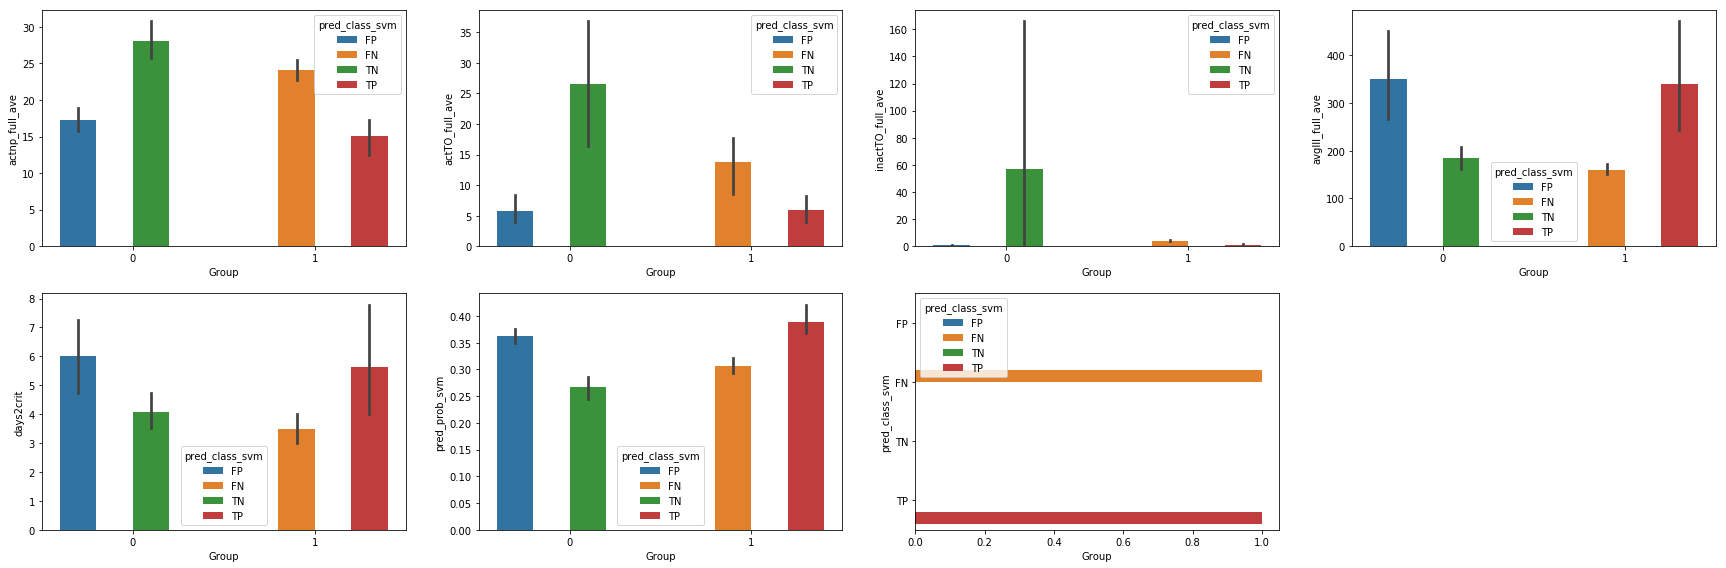

In [122]:
params = ['actnp_full_ave',
               'actTO_full_ave', 
                     'inactTO_full_ave',
                'avgIII_full_ave',
                     'days2crit',
          'pred_prob_svm',
       'pred_class_svm']

i=1
plt.figure(figsize=(30,20))
for param in params:
    print(param)
    plt.subplot(4, 4, i)
    sns.barplot(x=train["Group"], y=train[param], hue=train["pred_class_svm"])
    i = i + 1

In [123]:
#create new columns for each model's pred prob and the best model's pred class
test['class_svm'] = test_pred_svm
test['pred_prob_svm'] = test_pred_prob_svm[:,1]

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_svm'
test = conf_mat_column(test, model_name)
test.head()

,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_full_ave,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_full_ave,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_full_ave,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_full_ave,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_full_ave,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_full_ave,lat2fir_last_ave,lat2fir_first_ave,class_svm,pred_prob_svm,pred_class_svm
77,2861,0,2.0,1.0,2.0,4.0,3.0,41.0,34.0,29.0,29.0,6.0,23.357143,27.8,2.4,3.0,3.0,0.0,5.0,6.0,5.0,0.0,4.0,5.0,5.0,3.428571,3.8,3.4,1.0,0.0,0.0,2.0,0.0,24.0,6.0,5.0,3.0,2.0,20.142857,8.0,0.6,1797.490000,1404.110000,1404.110000,837.410000,1227.110000,86.686250,105.964848,123.022143,121.323214,639.434000,516.071005,215.286091,1334.046000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,8,957.58,292.17,99.80,34.09,261.04,2.67,0.26,28.32,47.08,14.68,134.855714,18.602,328.936,0,0.277701,TN
33,2284,0,5.0,15.0,17.0,15.0,17.0,40.0,30.0,37.0,7.0,42.0,23.666667,31.2,13.8,5.0,26.0,6.0,2.0,1.0,24.0,2.0,6.0,7.0,78.0,14.416667,23.4,8.0,4.0,5.0,0.0,11.0,6.0,42.0,9.0,50.0,8.0,81.0,20.666667,38.0,5.2,744.682500,232.832857,217.224375,218.526429,223.348750,84.617179,117.776207,96.852222,176.566111,84.597561,204.357613,112.081856,327.322982,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,13.0,1.416667,3.4,0.0,4,112.90,115.25,16.00,0.93,12.72,39.65,43.01,74.40,2675.06,12.33,261.857500,568.890,51.560,0,0.303173,TN
20,2768,1,4.0,3.0,1.0,2.0,5.0,19.0,9.0,9.0,11.0,15.0,7.772727,12.6,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.454545,0.4,0.6,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.954545,0.0,1.4,1126.416667,908.645000,1116.430000,1116.430000,639.092500,196.110556,429.833750,371.170000,305.308000,215.656429,612.938220,303.615747,981.402833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,11,194.77,314.63,644.30,15.48,116.23,13.65,96.45,13.49,10.80,409.42,220.654545,108.762,257.082,1,0.424029,TP
27,2248,0,35.0,22.0,23.0,15.0,15.0,34.0,40.0,37.0,31.0,2.0,25.400000,28.8,22.0,17.0,4.0,7.0,5.0,12.0,6.0,14.0,9.0,4.0,4.0,9.181818,7.4,9.0,24.0,5.0,2.0,0.0,4.0,7.0,18.0,20.0,17.0,1.0,9.800000,12.6,7.0,83.435588,154.888095,159.855455,225.647857,228.227857,107.067273,88.060000,94.680833,112.040000,835.030000,208.893296,247.375621,170.410970,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.400000,0.2,0.6,3,695.30,44.87,43.96,53.25,27.23,24.75,33.56,39.42,10.31,2673.74,364.639000,556.356,172.922,0,0.294323,TN
63,2748,0,5.0,9.0,7.0,6.0,10.0,21.0,23.0,24.0,22.0,24.0,15.384615,22.8,7.4,5.0,8.0,2.0,4.0,1.0,0.0,0.0,0.0,5.0,1.0,2.615385,1.2,4.0,6.0,6.0,4.0,5.0,1.0,4.0,1.0,2.0,1.0,3.0,3.307692,2.2,4.4,731.785000,398.102500,532.975000,638.966000,382.664445,171.705000,155.939546,153.675217,154.640000,149.006957,317.726946,156.993344,536.898589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,7,54.27,36.26,52.59,14.78,33.97,3.46,30.20,47.12,29.55,16.24,28.513077,25.314,38.374,1,0.376618,FP


actnp_full_ave
actTO_full_ave
inactTO_full_ave
avgIII_full_ave
days2crit
pred_prob_svm
pred_class_svm


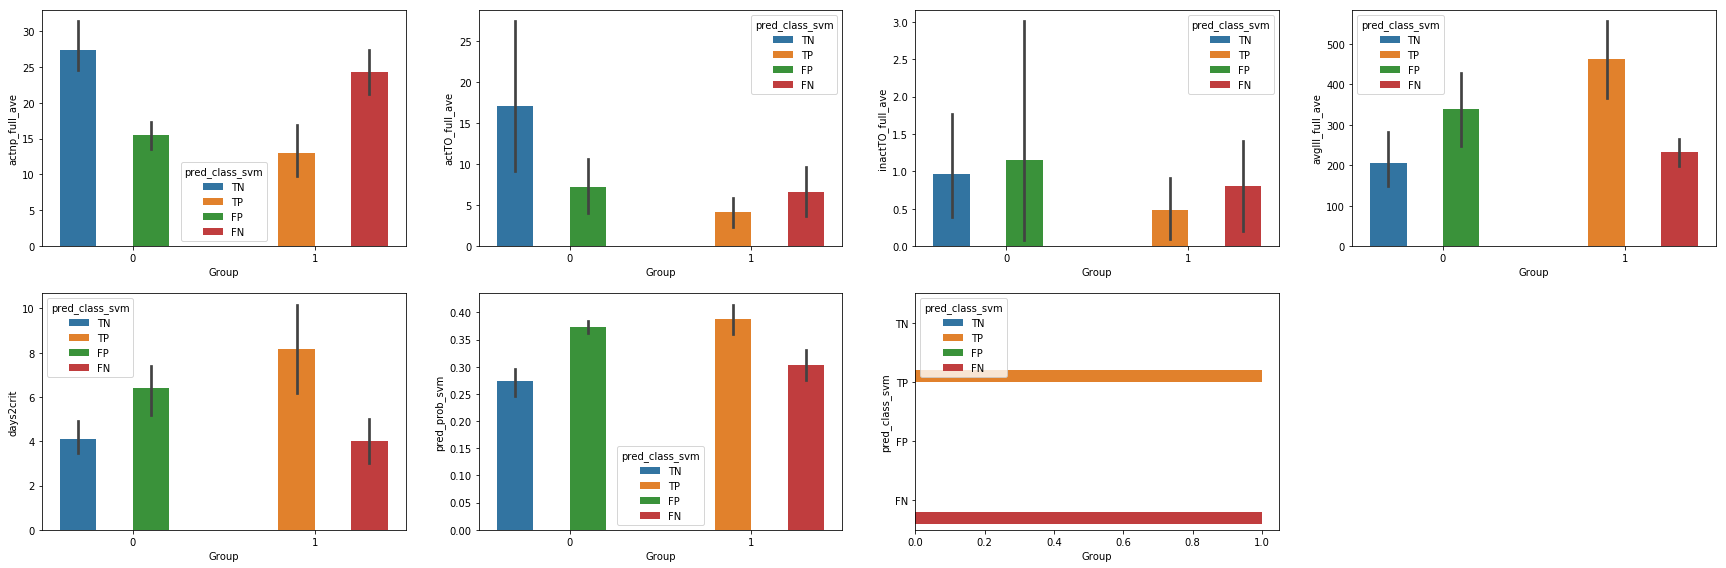

In [124]:
params = ['actnp_full_ave',
               'actTO_full_ave', 
                     'inactTO_full_ave',
                'avgIII_full_ave',
                     'days2crit',
          'pred_prob_svm',
       'pred_class_svm']

i=1
plt.figure(figsize=(30,20))
for param in params:
    print(param)
    plt.subplot(4, 4, i)
    sns.barplot(x=test["Group"], y=test[param], hue=test["pred_class_svm"])
    i = i + 1

In [125]:
test_params = test[['Animal', 'Group', 'class_svm', 'pred_prob_svm', 'pred_class_svm', 'actnp_full_ave',
               'actTO_full_ave', 
                     'inactTO_full_ave',
                'avgIII_full_ave',
                     'days2crit']].sort_values('pred_class_svm')

test_params.groupby('pred_class_svm').mean()

,Animal,Group,class_svm,pred_prob_svm,actnp_full_ave,actTO_full_ave,inactTO_full_ave,avgIII_full_ave,days2crit
pred_class_svm,,,,,,,,,
FN,2462.500000,1.0,0.0,0.302914,24.266667,6.668182,0.800000,231.457427,4.000000
FP,2560.200000,0.0,1.0,0.373424,15.530256,7.255781,1.155758,340.044228,6.400000
TN,2377.545455,0.0,0.0,0.273070,27.417080,17.045218,0.959032,206.438776,4.090909
TP,2680.833333,1.0,1.0,0.388434,12.952977,4.160305,0.480353,462.873193,8.166667


In [126]:
test_params

,Animal,Group,class_svm,pred_prob_svm,pred_class_svm,actnp_full_ave,actTO_full_ave,inactTO_full_ave,avgIII_full_ave,days2crit
9,2385,1,0,0.329910,FN,21.200000,3.636364,0.200000,264.397737,5
12,2540,1,0,0.275917,FN,27.333333,9.700000,1.400000,198.517118,3
42,2410,0,1,0.353153,FP,18.500000,12.666667,4.833333,209.723641,4
51,2530,0,1,0.364382,FP,17.100000,10.100000,0.400000,252.514727,6
69,2827,0,1,0.392378,FP,13.000000,6.454545,0.545455,436.945271,7
34,2286,0,1,0.380587,FP,13.666667,3.750000,0.000000,483.310557,8
63,2748,0,1,0.376618,FP,15.384615,3.307692,0.000000,317.726946,7
31,2282,0,0,0.306110,TN,23.900000,4.100000,0.000000,225.364131,4
32,2283,0,0,0.292863,TN,24.500000,13.555556,0.000000,257.571752,5
33,2284,0,0,0.303173,TN,23.666667,20.666667,1.416667,204.357613,4


### Voting Classifier

In [131]:
#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_full = train[features_full]
X_train_ave_full = train[features_ave_full]
X_train_ave_last = train[features_ave_last]
X_train_ave_firstlast = train[features_ave_firstlast]

X_test_full = test[features_full]
X_test_ave_full = test[features_ave_full]
X_test_ave_last = test[features_ave_last]
X_test_ave_firstlast = test[features_ave_firstlast]

X_train_scaled = scaler.fit_transform(X_train_ave_full)
X_test_scaled = scaler.fit_transform(X_test_ave_full)
 
eclf1 = VotingClassifier(estimators=[
        ('lr', lr_cv), ('rf', rf_cv), ('svm', svm_cv), ('knn', knn_cv), ('gb', gb_cv), ('ab', ab_cv)], 
                         voting='hard', weights=[5,1,1,1,1,5])
eclf1 = eclf1.fit(X_train_scaled, Y_train_class)
print('Train score with hard voting: ', eclf1.score(X_train_scaled, Y_train_class))
print('Test score with hard voting: ', eclf1.score(X_test_scaled, Y_test_class))
test_pred_hard = eclf1.predict(X_test_scaled)
print(classification_report(Y_test_class, test_pred_hard))
print(confusion_matrix(Y_test_class, test_pred_hard))

eclf2 = VotingClassifier(estimators=[
        ('lr', lr_cv), ('rf', rf_cv), ('svm', svm_cv), ('knn', knn_cv), ('gb', gb_cv), ('ab', ab_cv)], 
                         voting='soft', weights=[5,1,1,1,1,5])
eclf2 = eclf2.fit(X_train_scaled, Y_train_class)
print('Train score with soft voting: ', eclf2.score(X_train_scaled, Y_train_class))
print('Test score with soft voting: ', eclf2.score(X_test_scaled, Y_test_class))
test_pred_hard = eclf2.predict(X_test_scaled)
test_pred_prob_hard = eclf2.predict_proba(X_test_scaled)
print(classification_report(Y_test_class, test_pred_hard))
print(confusion_matrix(Y_test_class, test_pred_hard))


Train score with hard voting:  0.9285714285714286
Test score with hard voting:  0.8333333333333334
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.83      0.62      0.71         8

   micro avg       0.83      0.83      0.83        24
   macro avg       0.83      0.78      0.80        24
weighted avg       0.83      0.83      0.83        24

[[15  1]
 [ 3  5]]
Train score with soft voting:  0.9285714285714286
Test score with soft voting:  0.7083333333333334
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        16
           1       0.56      0.62      0.59         8

   micro avg       0.71      0.71      0.71        24
   macro avg       0.68      0.69      0.68        24
weighted avg       0.72      0.71      0.71        24

[[12  4]
 [ 3  5]]


### Recursive feature elimination for feature selection and model training evaluation

In [ ]:
data = X_train_ave_full

#scale data
X = scaler.fit_transform(data)
y = Y_train_class

svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', decision_function_shape='ovo', random_state=39)
selector = RFECV(svm_best, step=1, cv=3)
selector = selector.fit(X, y)
feature_rankings = list(zip(data.columns.values, selector.ranking_))

print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

feature_rankings

In [ ]:
all_features = ['actnp_first_ave', 'Inactnp_first_ave', 'actTO_first_ave',
       'avgIII_first_ave', 'inactTO_first_ave', 'lat2fir_first_ave',
       'days2crit', 'actnp_last_ave', 'Inactnp_last_ave',
       'actTO_last_ave', 'avgIII_last_ave', 'inactTO_last_ave',
       'lat2fir_last_ave']

cv5_features = ['actnp_first_ave', 'Inactnp_first_ave', 'actTO_first_ave', 'lat2fir_first_ave', 'actnp_last_ave', 
                 'Inactnp_last_ave', 'avgIII_last_ave', 'inactTO_last_ave']

cv3_features = ['lat2fir_first_ave', 'actnp_last_ave', 'Inactnp_last_ave']

In [ ]:
data = cv3_features

#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_rfe = train[data]

X_test_rfe = test[data]

In [ ]:
#scale data
data_scaled = scaler.fit_transform(X_train_rfe)

#grid search with cv for svm and ave last features
param_grid = {'C':(0.001, 0.01, 0.1, 1, 10), 'decision_function_shape':('ovo','ovr')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

svm_base = SVC(kernel='linear', class_weight='balanced', random_state=39)

svm_gs = GridSearchCV(svm_base, param_grid, cv=3, scoring = scoring, refit='f1')
svm_gs.fit(data_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(svm_gs, data_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_gs, data_scaled, Y_train_class, scoring='roc_auc'))))

print(svm_gs.best_params_)

In [ ]:
svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', C=10, decision_function_shape='ovo', random_state=39)
    
print("f1:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='accuracy'))))

In [ ]:
svm_best.fit(data_scaled, Y_train_class)
print(svm_best.score(data_scaled, Y_train_class))

#scale data
data_scaled_test = scaler.fit_transform(X_test_rfe)

print('SVM test AUC: {}'.format(svm_best.score(data_scaled_test, Y_test_class)))
test_pred_svm = svm_best.predict(data_scaled_test)
test_pred_prob_svm = svm_best.predict_proba(data_scaled_test)
print(classification_report(Y_test_class, test_pred_svm))
print(confusion_matrix(Y_test_class, test_pred_svm))

### Unsupervised 

In [ ]:
features_cluster = combined_data[['actnp_last_ave', 
                'Inactnp_last_ave', 
               'actTO_last_ave', 
                'avgIII_last_ave']]

# center and scale the data
scaler = StandardScaler()

features_clust_scaled = scaler.fit_transform(features_cluster)

In [ ]:
k_range = range(2,10)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(features_clust_scaled)
    scores.append(silhouette_score(features_clust_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=2,random_state=1234)
km2.fit(features_clust_scaled)
combined_data['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
combined_data.groupby('kmeans_2_scaled').mean()

In [ ]:
combined_data.groupby('Group')['kmeans_2_scaled'].value_counts()

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, random_state=1234)
tsne_features = tsne.fit_transform(features_clust_scaled)

print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = combined_data.index)
combined_data = pd.concat([combined_data, tsne_df], axis = 1)
combined_data.head()

In [ ]:
sns.pairplot(x_vars='tsne_0', y_vars='tsne_1', data=combined_data, hue='Group')
plt.show()
sns.pairplot(x_vars='tsne_0', y_vars='tsne_1', data=combined_data, hue='kmeans_2_scaled')
plt.show()